The purpose of this notebook is to determine how well place at the 5k mark (in terms of time needed to get there) correlates with overall finishing place.

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [4]:
df = pd.read_csv('data/mens_speed.csv')

In [5]:
speed_cols = ['5k_speed', '10k_speed', '15k_speed', '20k_speed', '25k_speed', '30k_speed', '35k_speed', '40k_speed']
split_cols = ['5k_split', '10k_split', '15k_split', '20k_split', '25k_split', '30k_split', '35k_split', '40k_split']
avg_speed_cols = ['10k_avg_speed', '15k_avg_speed', '20k_avg_speed', '25k_avg_speed', \
                  '30k_avg_speed', '35k_avg_speed', '40k_avg_speed', 'last_2k_speed', 'final_avg_speed']

In [6]:
df[speed_cols] = df[speed_cols].apply(pd.to_numeric)
df[split_cols] = df[split_cols].apply(pd.to_numeric)
df[avg_speed_cols] = df[avg_speed_cols].apply(pd.to_numeric)

In [5]:
df.head()

,div_place,name,bib,age,place,gender_place,5k_split,10k_split,15k_split,20k_split,...,40k_speed,last_2k_speed,10k_avg_speed,15k_avg_speed,20k_avg_speed,25k_avg_speed,30k_avg_speed,35k_avg_speed,40k_avg_speed,final_avg_speed
0,1,EDGAR YAK DE PADUA,41626,14,472,445,22.366667,44.700000,67.033333,89.466667,...,3.209243,1.212038,3.728561,3.729488,3.725782,3.679717,3.598848,3.508772,3.468308,3.464286
1,2,DAVID ROMAN,40554,15,505,473,24.783333,47.233333,68.916667,91.416667,...,3.004808,1.808072,3.528582,3.627570,3.646308,3.643784,3.604037,3.529293,3.453933,3.447022
2,3,RONALD PINEDA,41123,13,549,509,22.833333,45.566667,68.183333,90.633333,...,3.172589,1.199454,3.657644,3.666585,3.677823,3.642191,3.569304,3.483627,3.441452,3.414387
3,4,ROBERT HAWRYLO,41574,15,646,596,25.566667,48.433333,71.500000,94.866667,...,3.207184,1.679419,3.441156,3.496503,3.513703,3.498461,3.451450,3.396739,3.371828,3.368056
4,5,BRYAN SON,40561,14,711,654,25.083333,50.083333,74.183333,97.916667,...,3.094059,2.337593,3.327787,3.370029,3.404255,3.415301,3.406381,3.371544,3.334167,3.341120


In [7]:
df['5k_split'].quantile(.01)

20.133333333333333

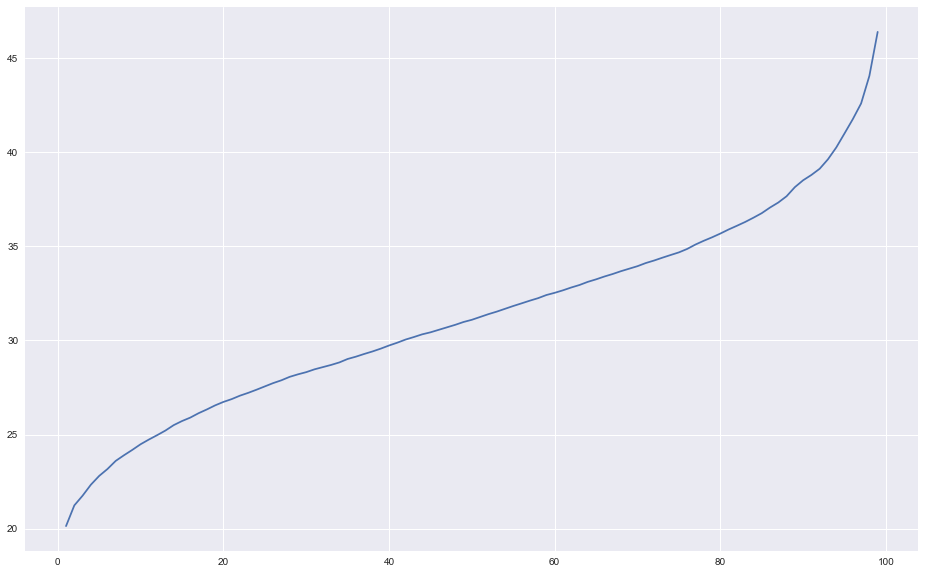

In [65]:
fig = plt.figure(figsize=(16, 10))

x = np.arange(0.01,1,0.01)
y = [df['5k_split'].quantile(q) for q in x]

plt.plot(100*x, y)

In [16]:
x = np.arange(0.01,1.01,0.01)
quantiles_5k = [df['5k_split'].quantile(q) for q in x]
quantiles_place = [df['place'].quantile(q) for q in x]

df[df['5k_split'] <= quantiles_5k[0]]['bib'].isin(df[df['place'] <= quantiles_place[0]]['bib']).sum() \
    / len(df[df['place'] <= quantiles_place[0]]['bib'])

0.64423076923076927

In [23]:
df[df['5k_split'].between(quantiles_5k[0], quantiles_5k[1])]['bib'].isin(df[df['place'] <= quantiles_place[0]]['bib']).sum() / len(df[df['place'] <= quantiles_place[0]]['bib'])

0.23076923076923078

In [36]:
def top_one_pct_by_pace(lower_pace_quantile, upper_pace_quantile):
    top_one_pct = df[df['place'] <= df['place'].quantile(0.01)]
    pct = df[df['5k_split'].between(df['5k_split'].quantile(lower_pace_quantile), df['5k_split'].quantile(upper_pace_quantile))]['bib'].isin(top_one_pct['bib']).sum() / len(top_one_pct)
    return pct

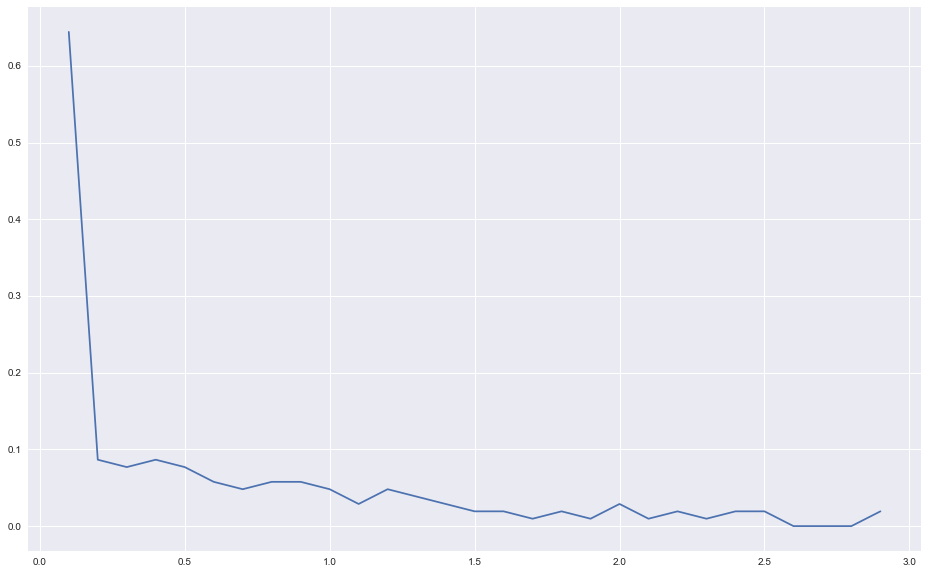

In [69]:
fig = plt.figure(figsize=(16, 10))

x = np.arange(0.001,0.03,0.001)
y_top_one_pct = [top_one_pct_by_pace(n, n+0.001) for n in x]
y_top_one_pct.insert(0,df[df['5k_split'] <= quantiles_5k[0]]['bib'].isin(df[df['place'] <= quantiles_place[0]]['bib']).sum() \
    / len(df[df['place'] <= quantiles_place[0]]['bib']))

plt.plot(100*x, y_top_one_pct[:-1])

We'll now build a linear model to predict placing using only the 5k split. The accuracy will be evaluated using MSE between the predicted placing and the actual placing.

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

In [22]:
reg = LinearRegression()

X = df['5k_split'].as_matrix().reshape((len(df['5k_split']), 1))
y = df['place'].as_matrix().reshape((len(df['5k_split']), 1))

cv_score_MSE = cross_val_score(reg, X=X, y=y, scoring='neg_mean_squared_error', cv=5)
print("MSE Cross Validation Results\nMean: {}\nStd. Dev.: {}\n".format(-np.mean(cv_score_MSE), np.std(cv_score_MSE)))

cv_score_R2 = cross_val_score(reg, X=X, y=y, cv=5)
print("R^2 Cross Validation Results\nMean: {}\nStd. Dev.: {}".format(np.mean(cv_score_R2), np.std(cv_score_R2)))

MSE Cross Validation Results
Mean: 10053170.599975113
Std. Dev.: 796386.0676187

R^2 Cross Validation Results
Mean: 0.6207432348230668
Std. Dev.: 0.04232063641205509
